---
## Load packages and libraries
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

from sentiment_analysis.preprocessing import processtext

---
## Load model Word2Vec and Data
---

In [2]:
from w2v import movieFeedbackWord2Vec

w2v_skipgram = movieFeedbackWord2Vec()
w2v_skipgram.load("vec_models/skipgram_model.bin")

In [3]:
df_train = pd.read_csv("sentiment_analysis/Train.csv")
X_train = df_train["review"]
y_train = df_train["sentiment"]

df_dev = pd.read_csv("sentiment_analysis/Dev.csv")
X_dev = df_dev["review"]
y_dev = df_dev["sentiment"]

df_test = pd.read_csv("sentiment_analysis/Test.csv")
X_test = df_test["review"]
y_test = df_test["sentiment"]

In [5]:
corpus_df = pd.read_csv("sentiment_analysis/corpus.csv")
X = corpus_df["review"]
y = corpus_df["sentiment"]

---
## Sentiment
---

### Processing and Transform Data

In [6]:
def tokenize_review_sentence(sentence):
    return word_tokenize(processtext(sentence))

X_tokenized = [tokenize_review_sentence(x) for x in X]

In [7]:
class Sequencer:
    def __init__(self, all_words, max_words, seq_len, embedding_matrix ):
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        count = 0
        while count + 1 != len(counts):
            count = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    count += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        tokens = word_tokenize(text)
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for token in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix.get_vector(token))
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(150,))
        
        return np.asarray(vec).flatten()

In [11]:
sequencer = Sequencer(all_words = [token for seq in X_tokenized for token in seq],
              max_words = 9500,
              seq_len = 95,
              embedding_matrix = w2v_skipgram
             )

In [12]:
X_train_vector = [sequencer.textToVector(x) for x in X_train]

### MaxEnt (Ridge Regression)

In [20]:
ridge_classifier = RidgeClassifier(alpha=0.2)
ridge_classifier.fit(X_train_vector, y_train)

RidgeClassifier(alpha=0.2)

In [21]:
X_test_vector = [sequencer.textToVector(x) for x in X_test]
ridge_predictions = ridge_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, ridge_predictions))

ridge_accuracy = accuracy_score(y_test, ridge_predictions)
ridge_precision = precision_score(y_test, ridge_predictions, average="weighted")
ridge_recall = recall_score(y_test, ridge_predictions, average="weighted")
ridge_f1 = f1_score(y_test, ridge_predictions, average="weighted")

print("Accuracy: ", ridge_accuracy)
print("Precision: ", ridge_precision)
print("Recall: ", ridge_recall)
print("F1-Score: ", ridge_f1)

Confusion Matrix:
[[1700  769]
 [ 703 1778]]
Accuracy:  0.7026262626262626
Precision:  0.7027512340131283
Recall:  0.7026262626262626
F1-Score:  0.7025637685863182


In [22]:
lr_result = classification_report(y_test, ridge_predictions)
print(lr_result)

              precision    recall  f1-score   support

    negative       0.71      0.69      0.70      2469
    positive       0.70      0.72      0.71      2481

    accuracy                           0.70      4950
   macro avg       0.70      0.70      0.70      4950
weighted avg       0.70      0.70      0.70      4950



<Axes: >

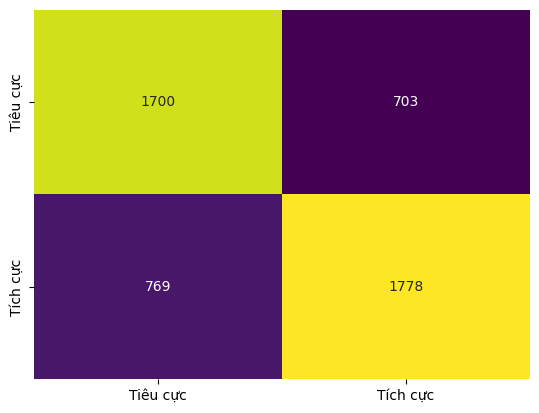

In [23]:
lr_conf_matrix = confusion_matrix(ridge_predictions, y_test)
sns.heatmap(lr_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
                 xticklabels=["Tiêu cực", "Tích cực"], yticklabels=["Tiêu cực", "Tích cực"])

In [25]:
example = "The plot twtist is really good, but the cgi is so terrible."
vector = np.array([sequencer.textToVector(example)])
result = ridge_classifier.predict(vector)
print("Sentiment: ", result[0])

Sentiment:  negative


### SVM 

In [32]:
SVM_classifier = SVC()
SVM_classifier.fit(X_train_vector, y_train)

SVC()

In [33]:
SVM_predictions = SVM_classifier.predict(X_test_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_test, SVM_predictions))

SVM_accuracy = accuracy_score(y_test, SVM_predictions)
SVM_precision = precision_score(y_test, SVM_predictions, average="weighted")
SVM_recall = recall_score(y_test, SVM_predictions, average="weighted")
SVM_f1 = f1_score(y_test, SVM_predictions, average="weighted")

print("Accuracy: ", SVM_accuracy)
print("Precision: ", SVM_precision)
print("Recall: ", SVM_recall)
print("F1-Score: ", SVM_f1)

Confusion Matrix:
[[1725  744]
 [ 630 1851]]
Accuracy:  0.7224242424242424
Precision:  0.7228661773286787
Recall:  0.7224242424242425
F1-Score:  0.7222614148257209


In [34]:
svm_result = classification_report(y_test, SVM_predictions)
print(svm_result)

              precision    recall  f1-score   support

    negative       0.73      0.70      0.72      2469
    positive       0.71      0.75      0.73      2481

    accuracy                           0.72      4950
   macro avg       0.72      0.72      0.72      4950
weighted avg       0.72      0.72      0.72      4950



<Axes: >

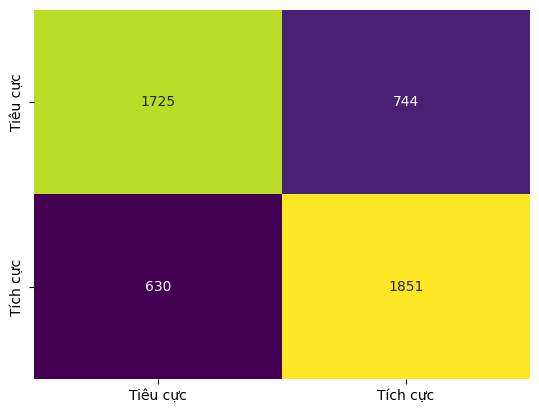

In [35]:
svm_conf_matrix = confusion_matrix( y_test, SVM_predictions)
sns.heatmap(svm_conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
                 xticklabels=["Tiêu cực", "Tích cực"], yticklabels=["Tiêu cực", "Tích cực"])

In [36]:
example = "The plot twtist is really good, but the cgi is so terrible."
vector = np.array([sequencer.textToVector(example)])
result = SVM_classifier.predict(vector)
print("Sentiment: ", result)

Sentiment:  ['negative']


## Save Model

In [37]:
import joblib

joblib.dump(ridge_classifier, 'ml_models/w2v_ridge_model.pkl')

joblib.dump(SVM_classifier, 'ml_models/w2v_svm_model.pkl')

['models/w2v_svm_model.pkl']

In [ ]:
X_dev_vector = [sequencer.textToVector(x) for x in X_dev]

In [42]:
ridge_model = joblib.load("ml_models/w2v_ridge_model.pkl")

ridge_predictions = ridge_model.predict(X_dev_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_dev, ridge_predictions))

ridge_accuracy = accuracy_score(y_dev, ridge_predictions)
ridge_precision = precision_score(y_dev, ridge_predictions, average="weighted")
ridge_recall = recall_score(y_dev, ridge_predictions, average="weighted")
ridge_f1 = f1_score(y_dev, ridge_predictions, average="weighted")

print("Accuracy: ", ridge_accuracy)
print("Precision: ", ridge_precision)
print("Recall: ", ridge_recall)
print("F1-Score: ", ridge_f1)

Confusion Matrix:
[[3440 1502]
 [1552 3556]]
Accuracy:  0.6961194029850746
Precision:  0.6961887667541781
Recall:  0.6961194029850746
F1-Score:  0.6961368554471723


In [6]:
svm_model = joblib.load("ml_models/w2v_svm_model.pkl")

svm_predictions = svm_model.predict(X_dev_vector)

print("Confusion Matrix:")
print(confusion_matrix(y_dev, svm_predictions))

svm_accuracy = accuracy_score(y_dev, svm_predictions)
svm_precision = precision_score(y_dev, svm_predictions, average="weighted")
svm_recall = recall_score(y_dev, svm_predictions, average="weighted")
svm_f1 = f1_score(y_dev, svm_predictions, average="weighted")

print("Accuracy: ", svm_accuracy)
print("Precision: ", svm_precision)
print("Recall: ", svm_recall)
print("F1-Score: ", svm_f1)

NameError: name 'X_dev_vector' is not defined